In [10]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

In [11]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [12]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=2)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [13]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [14]:
Params={'L': 15, 'P': 0.3780703389644099, 'Inh': 0.6358066855917539, 'Trest': -4.739855306871973, 'Trelative': -0.5845066272055987, 'C_h': 0.984180380236879, 'Tipo_red': 2}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_9083/1061044799.py:38: RuntimeWarning: joblib not installed. Cannot run in parallel.
  psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=2)


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


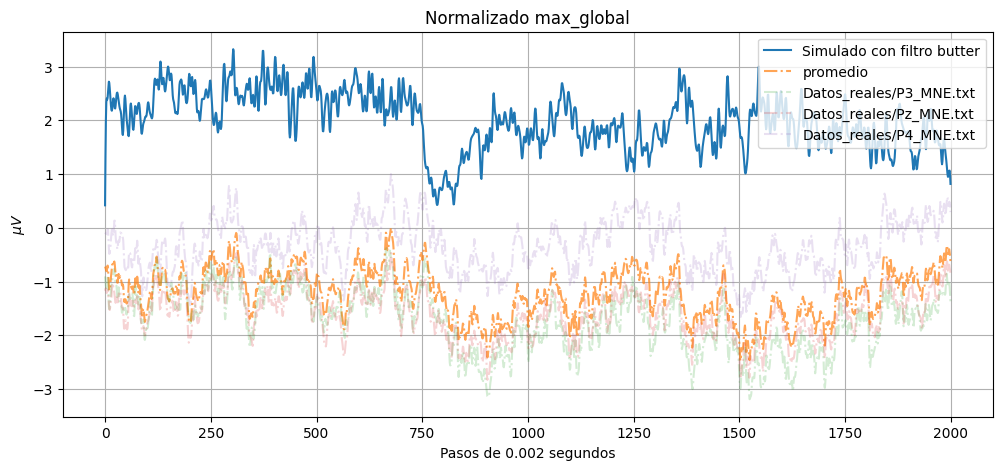

In [15]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75]
481
481
241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [np.float64(-13.651222923027593), np.float64(3.1169780642171547)] ---- [-16.27827059   2.88417163]
Theta [np.float64(-20.85326021813477), np.float64(1.8580723684401772)] ---- [-20.92087743   1.24854708]
Alpha [np.float64(-25.958923673368595), np.float64(2.8354345051516474)] ---- [-23.45952953   1.6550146 ]
Beta [np.float64(-29.557171677371898), np.float64(1.736265477461653)] ---- [-30.85933893   2.14572916]


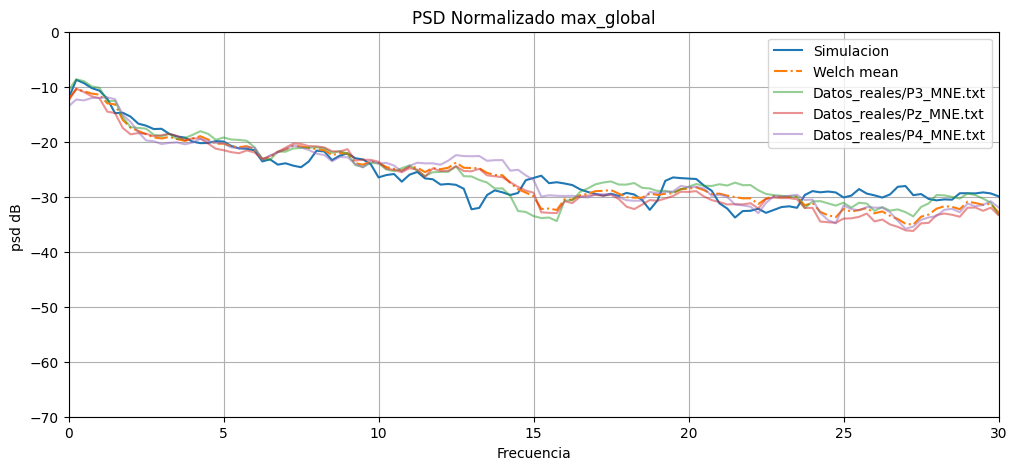

In [16]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [19]:
import tensorflow as tf
import numpy as np
from scipy.stats import chisquare

def chi_squared(params):
    generated_data_total = Simulado_EGG(params, Normalizacion)

    # Asegúrate de que esto use los tensores correctamente
    chi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
    
    return tf.convert_to_tensor(chi2_stat, dtype=tf.float32)  # Devuelve un tensor

# Definir los límites de los parámetros
def initialize_params():
    L = np.random.randint(10, 21)  # L entre 10 y 20 (incluyendo ambos)
    P = np.random.uniform(0.0, 1.0)  # P entre 0.0 y 1.0
    Inh = np.random.uniform(0.0, 1.0)  # Inh entre 0.0 y 1.0
    Trest = np.random.uniform(0.0, 10.0)  # Trest entre 0.0 y 10.0
    Trelative = np.random.uniform(Trest, Trest + 10.0)  # Trelative entre Trest y Trest + 10.0
    C_h = np.random.uniform(0.0, 1.0)  # C_h entre 0.0 y 1.0
    fixed_param = 8050  # Este parámetro es fijo
    Tipo_red = np.random.randint(0, 5)  # Tipo_red entre 0 y 4 (incluyendo ambos)
    
    return tf.convert_to_tensor([L, P, Inh, Trest, Trelative, C_h, fixed_param, Tipo_red], dtype=tf.float32)

# Inicializar parámetros aleatorios
initial_params = tf.Variable(initialize_params(), dtype=tf.float32)

# Definir el optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Definir el número de iteraciones
num_iterations = 100

# Optimización
for i in range(num_iterations):
    with tf.GradientTape() as tape:
        # No convertir a numpy, mantén todo como tensores
        params_to_evaluate = tf.identity(initial_params)  # Copia de los parámetros como tensor
        
        # Asegurarse de que L y Tipo_red sean enteros
        params_to_evaluate = tf.Variable(params_to_evaluate)  # Esto asegura que se puedan modificar
        params_to_evaluate = tf.concat([params_to_evaluate[:1], params_to_evaluate[1:-1], tf.cast(params_to_evaluate[-1:], tf.int32)], axis=0)
        
        # Calculamos el valor de la función objetivo
        loss_value = chi_squared(params_to_evaluate)

    # Calculamos los gradientes
    grads = tape.gradient(loss_value, [initial_params])

    # Aplicamos los gradientes para actualizar los parámetros
    optimizer.apply_gradients(zip(grads, [initial_params]))

    if i % 10 == 0:  # Imprimir cada 10 iteraciones
        print(f"Iteración {i}: Chi-cuadrado = {loss_value:.4f}, Parámetros = {initial_params.numpy()}")

# Convertir L y Tipo_red a enteros para mostrar resultados
final_params = initial_params.numpy()
final_params[0] = int(final_params[0])  # L como entero
final_params[7] = int(final_params[7])  # Tipo_red como entero

print("Parámetros optimizados:", final_params)
print("Valor mínimo del chi-cuadrado:", chi_squared(final_params))


InvalidArgumentError: cannot compute ConcatV2 as input #2(zero-based) was expected to be a float tensor but is a int32 tensor [Op:ConcatV2] name: concat

In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi30_max_global_L10

Trial 1:
Params: {'L': 19, 'P': 0.06579203509200594, 'Inh': 0.6469350735727993, 'Trest': 1.3345000595355676, 'Trelative': 3.4891758600570033, 'C_h': 0.5656801320643629, 'Tipo_red': 4}
Value: 84.08659793910752

Trial 2:
Params: {'L': 19, 'P': 0.10680744307464834, 'Inh': 0.5821058798079192, 'Trest': 1.0543315190082365, 'Trelative': 3.4329352802164963, 'C_h': 0.5204061068566, 'Tipo_red': 4}
Value: 85.61876940982138

Trial 3:
Params: {'L': 19, 'P': 0.09304649640090151, 'Inh': 0.5697494515310005, 'Trest': 1.1996753737842751, 'Trelative': 3.9149973571106127, 'C_h': 0.5322225749991866, 'Tipo_red': 4}
Value: 87.21893985278572

Trial 4:
Params: {'L': 19, 'P': 0.09344547190332858, 'Inh': 0.5683080121623615, 'Trest': 0.9172755746430205, 'Trelative': 3.8464061683732234, 'C_h': 0.5169366418089703, 'Tipo_red': 4}
Value: 106.3620721349206

Trial 5:
Params: {'L': 19, 'P': 0.10146579330142069, 'Inh': 0.5917967380203604, 'Trest': 1.0676782026463403, 'Trelative': 3.9479170392383844,

In [18]:
vis.plot_param_importances(study)

NameError: name 'study' is not defined

In [37]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

[W 2024-11-04 17:11:48,393] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,393] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 86 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 97 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 113 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 118 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 127 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,396] Trial 131 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,3